# Problem Statement

## Table of Contents
- [Data Cleaning](#Data-Cleaning)
    - [Submissions](#Submissions)
    - [Comments](#Comments)
    - [Users](#Users)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Submissions](#Submissions-EDA)
    - [Comments](#Comments-EDA)
    - [Users](#Users-EDA)
- [Modeling](#Modeling)
- [Results & Conclusions](#Results-&-Conclusions)
- [Next Steps](#Next-Steps)

### Imports

In [1]:
import configparser
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from aws_mysql import MySqlConn
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

### Functions

In [2]:
def bool_to_int(df_o, bool_cols):
    """
    Takes a DataFrame and list of boolean columns and maps the boolean values
    to integers. Does not work with strings.
    :param: Pandas DataFrame.
    :param: List of column names of booleans.
    :return: Pandas DataFrame.
    """
    bool_func = lambda x: 1 if x else 0
    df_ = df_o.copy()
    for col in bool_cols:
        df_[col] = df_[col].map(bool_func)
    return df_
    
# Dates ---------------------------------------------------------------------
def convert_epoch(df_o, epoch_col, 
                  year=False, month=False, dayofweek=False, hour=False):
    """
    Takes a the DataFrame and converts a column of epoch datetime to a
    datetime object. The original column is dropped and a new column
    'created_date' is added to the dataframe. 
    :param df_: Pandas DataFrame with a column of datetime in epoch format.
    :param epoch_col: Name of column with epoch datetime.
    :param year: Boolean Optional (Default True), whether a 'year' column is 
    created. 
    :param month: Boolean Optional (Default True), whether a 'month' column is
    created.
    :param dayofweek: Boolean Optional (Default True), whether a 'day_of_week'
    column is created.
    :param hour: Boolean Optional (Default True), whether a 'hour' column is
    created.
    :return: Pandas DataFrame.
    """
    df_ = df_o.copy()
    df_['created_date'] = pd.to_datetime(df_[epoch_col], unit='s')
    
    if year:
        df_['created_year'] = df_['created_date'].dt.year
    if month:
        df_['created_month'] = df_['created_date'].dt.month
    if dayofweek:
        df_['created_day_of_week'] = df_['created_date'].dt.dayofweek
    if hour:
        df_['created_hour'] = df_['created_date'].dt.hour
    
    return df_

# NLP -----------------------------------------------------------------------
def clean_submission_df(df_o):
    """
    Takes DataFrame and drops na values, duplicates, empty 'selftext' columns,
    and pinned content.
    :param df_o: pandas Dataframe to clean.
    :return: pandas DataFrame.
    """
    df_ = df_o.copy()
    df_.dropna(inplace=True)  # cannot fix na values of selftext
    df_.drop_duplicates(subset=['id'], inplace=True)  # init check
    df_ = df_[~df_['selftext'].isin(['[deleted]', '[removed]'])]
    df_ = df_[~df_['pinned']]  # pinned content is most likely rules/faq/etc
    return df_


# cleans text using all cleaning functions
def clean_text(X, word_list=[]):
    """
    
    """
    # order is very important
    X = replace_url(X)
    X = replace_amp(X)
    X = replace_nbsp(X)
    X = replace_newline(X)
    X = replace_nonalpha(X)
    X = replace_small_words(X)
    X = remove_words(X, word_list)
    return X


def replace_url(X):
    """
    Takes pandas series of text and removes urls.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('http\S+|www.\S+', '', case=False)  # ref 1


def replace_amp(X):
    """
    Takes pandas series of text and removes '&'.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('&amp;', ' ', regex=False)


def replace_nbsp(X):
    """
    Takes pandas series of text and removes 'nbsp'.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('nbsp;', ' ', regex=False)


def replace_newline(X):
    """
    Takes pandas series of text and removes '\n'.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('\n', ' ', regex=False)


def replace_nonalpha(X):
    """
    Takes pandas series of text and non alpha characters.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace('[^a-zA-Z ]', ' ')  # ref 2 


def replace_small_words(X):
    """
    Takes pandas series of text and removes words below 4 characters.
    :param X: Pandas series.
    :return: Pandas series.
    """
    return X.str.replace(r'\b[a-zA-Z]{1,3}\b', '')  # ref 3


def remove_words(X, words=[]):
    """
    Takes pandas series of text and removes `words`.
    :param X: Pandas series.
    :param words: List of strings, words to be removed from text 
    (case sensitive).
    :return: Pandas series.
    """
    for word in words:
        X = X.str.replace(word, '')
    return X

## Data

In [3]:
# get data from AWS rds
config = configparser.ConfigParser()
config.read('./config.ini')

db = MySqlConn(endpoint = config['rds']['endpoint'], 
               user     = config['rds']['user'], 
               password = config['rds']['password'], 
               dbname   = config['rds']['dbname'])

db.connect()

comments_df = pd.read_sql("""SELECT * FROM comments""", db.conn)
users_df    = pd.read_sql("""SELECT * FROM users""", db.conn)

db.close()

In [4]:
# if no such file is found, check the README for instructions
submissions_df = pd.read_csv('./data/submissions.csv')

C:\Users\Sam\anaconda3\envs\ga-dsir-capstone\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12,21,33,36,37,39,40,43,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,74,75,77,79,81,82,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,116,117,118,120) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Cleaning
* Drop Features that are not helpful.
* Impute or remove null values

### Submissions

In [5]:
submissions_df.shape

(86657, 122)

**Selftext**

In [6]:
submissions_df['selftext'].isna().sum() / submissions_df.shape[0]

0.4170465167268657

41.7+ percent of the `selftext` of submissions are blank. There could be many reasons for this:
- Might be media of some sort: image, video
- Could be link to article/content on another website
- All necessary text fit into the title

Fill null `selftext` with a blank string, `''`. No other way to impute values.

In [7]:
submissions_df['selftext'].fillna('', inplace=True)

**Select Columns**  
Automatically drop columns with greater than 50% null values as `selftext` is missing ~42%. Also looked through columns manually to add to keep_cols if they seem useful.

In [8]:
drop_cols = submissions_df.columns[submissions_df.isna().sum() / submissions_df.shape[0] > 0.50].values
drop_cols = set(drop_cols)

submissions_df.drop(columns=(drop_cols)).columns

Index(['author', 'author_fullname', 'created_utc', 'domain', 'full_link', 'id',
       'is_self', 'locked', 'media_embed', 'num_comments', 'over_18',
       'permalink', 'retrieved_on', 'score', 'secure_media_embed', 'selftext',
       'stickied', 'subreddit', 'subreddit_id', 'thumbnail', 'title', 'url',
       'search_term', 'period'],
      dtype='object')

In [9]:
# reviewed all columns and decided on this list
keep_cols = [
    'author',
    'created_utc', 
    'domain', 
    'id',
    'is_self',
    'num_comments', 
    'over_18',
    'score', 
    'selftext',
    'stickied', 
    'subreddit', 
    'thumbnail', 
    'title',
    'promoted',
    'search_term', 
    'period',
    'full_link'
]

In [10]:
submissions_df = submissions_df[keep_cols]

**Check for Null Values for Selected Columns**

In [11]:
submissions_df.isna().sum() / submissions_df.shape[0]

author          0.000012
created_utc     0.000000
domain          0.000035
id              0.000000
is_self         0.000000
num_comments    0.000000
over_18         0.000000
score           0.000000
selftext        0.000000
stickied        0.054502
subreddit       0.000992
thumbnail       0.000012
title           0.000000
promoted        0.994542
search_term     0.000000
period          0.000000
full_link       0.000000
dtype: float64

In [12]:
submissions_df.describe()

,created_utc,num_comments,score
count,8.665700e+04,86657.000000,86657.000000
mean,1.507940e+09,14.525162,16.037804
std,9.230622e+07,130.187857,171.480920
min,1.284756e+09,-3.000000,0.000000
25%,1.447190e+09,0.000000,1.000000
50%,1.463432e+09,2.000000,1.000000
75%,1.607565e+09,7.000000,1.000000
max,1.612742e+09,16057.000000,9631.000000


**Number of Comments**  
Replace negative number of comments with 0.

In [13]:
submissions_df[submissions_df['num_comments'] < 0] = 0

**Author**  
`author_fullname` and `author_id` columns are also null when `author` is null.

In [14]:
submissions_df[submissions_df['author'].isna()]

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,stickied,subreddit,thumbnail,title,promoted,search_term,period,full_link
68237,NaN,1.302772e+09,gameshampoo.com,gps20,False,50.0,False,0.0,,NaN,promos,http://thumbs.reddit.com/t3_gps20.png?v=d26045...,Win a free copy of Portal 2!,True,Portal 2,pre launch,https://www.reddit.com/comments/gps20/win_a_fr...


Assuming that if `author` is null then it is equivalent to `'[deleted]'`

In [15]:
submissions_df['author'].fillna('[deleted]', inplace=True)
submissions_df['author_deleted'] = submissions_df['author']\
                                    .map(lambda x: 1 
                                         if x == '[deleted]' 
                                         else 0)

In [16]:
submissions_df['author_deleted'].value_counts()

0    78183
1     8474
Name: author_deleted, dtype: int64

**Domain**

In [17]:
submissions_df[submissions_df['domain'].isna()]

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,stickied,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted
78364,feathand,1.584221e+09,NaN,fipqxs,False,0.0,False,1.0,,False,Metal,default,Music Similiar to Doom (2016) and Doom Eternal...,NaN,DOOM Eternal,pre launch,https://www.reddit.com/r/Metal/comments/fipqxs...,0
83248,zitping,1.584839e+09,NaN,fmr2o1,False,4.0,False,1.0,,False,Doom,default,[Troubleshooting] Doom Eternal - Constant cras...,NaN,DOOM Eternal,post launch,https://www.reddit.com/r/Doom/comments/fmr2o1/...,0
83450,Xenix1252,1.584852e+09,NaN,fmu6uk,False,5.0,False,1.0,,False,Doom,spoiler,Samuel Hayden and his role in the story of the...,NaN,DOOM Eternal,post launch,https://www.reddit.com/r/Doom/comments/fmu6uk/...,0


In [18]:
submissions_df['domain']

0              self.Fallout
1         self.pcmasterrace
2              self.Fallout
3                  self.fo4
4               youtube.com
                ...        
86652    self.buildapcforme
86653        self.GamerPals
86654         self.Trophies
86655     self.CrackSupport
86656     self.pcmasterrace
Name: domain, Length: 86657, dtype: object

`is_self` is False, unsure how to impute, so drop rows.

**Stickied**

In [19]:
submissions_df['stickied'].value_counts()

False    81866
True        70
Name: stickied, dtype: int64

In [20]:
submissions_df[submissions_df['stickied'].isna()].head()

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,stickied,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted
67260,ghkjdfhgjsdhgjklfhjk,1.313025e+09,self.gaming,jf77c,True,7.0,False,3.0,I'm torn.,NaN,gaming,self,Bastion or From Dust?,NaN,Bastion,pre launch,https://www.reddit.com/r/gaming/comments/jf77c...,0
67261,masamagic,1.313026e+09,self.tf2trade,jf7qj,True,0.0,False,0.0,"Trading Bills, V. Whiskers and some other hats...",NaN,tf2trade,self,"[W] Bastion [H] Bill's, V Whiskers + More",NaN,Bastion,pre launch,https://www.reddit.com/r/tf2trade/comments/jf7...,0
67262,[deleted],1.313030e+09,self.SteamGameSwap,jf9qc,True,0.0,False,1.0,,NaN,SteamGameSwap,default,"[H] Amnesia: Dark Decent, Audiosurf, Day of De...",NaN,Bastion,pre launch,https://www.reddit.com/r/SteamGameSwap/comment...,1
67263,buggereet,1.313031e+09,self.SteamGameSwap,jfa9c,True,0.0,False,1.0,,NaN,SteamGameSwap,self,"[H] Audiosurf, Cogs, Portal (pick two) [W] Bas...",NaN,Bastion,pre launch,https://www.reddit.com/r/SteamGameSwap/comment...,0
67264,[deleted],1.313046e+09,self.SteamGameSwap,jfgtf,True,0.0,False,1.0,Just want to put out there that I am not inter...,NaN,SteamGameSwap,default,"[H] Terraria, LIMBO, Beat Hazard Complete [W] ...",NaN,Bastion,pre launch,https://www.reddit.com/r/SteamGameSwap/comment...,1


There are only 70 total stickied submissions vs the 81,864 non-stickied. Additionally, the no clear way to check if null values were sticked or not. So, drop the column.

In [21]:
submissions_df.drop(columns='stickied', inplace=True)

**Subreddit**

In [22]:
submissions_df[submissions_df['subreddit'].isna()].head()

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted
133,[deleted],1.446605e+09,rareitemapparel.com,3rfx7v,False,0.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/KS4dX5huaXN0z2...,How I feel waiting for Fallout 4...,True,Fallout 4,pre launch,https://www.reddit.com/comments/3rfx7v/how_i_f...,1
1503,SickAcorn,1.446701e+09,twitch.tv,3rleos,False,0.0,False,1.0,,NaN,default,Fallout 4 stream,True,Fallout 4,pre launch,https://www.reddit.com/comments/3rleos/fallout...,0
1862,LERAGESHIRTS,1.446736e+09,lerageshirts.com,3rmwzr,False,1.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/ywNvlxU8A6IJzm...,In case you need this for the 400 hours of gam...,True,Fallout 4,pre launch,https://www.reddit.com/comments/3rmwzr/in_case...,0
8485,redditads,1.447135e+09,redbox.com,3s8nwi,False,146.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/qBWq8Bt-YaF38q...,"Gaming on a budget? For just $3 a day, you can...",True,Fallout 4,post launch,https://www.reddit.com/comments/3s8nwi/gaming_...,0
8504,redditads,1.447135e+09,redbox.com,3s8of5,False,134.0,False,0.0,,NaN,http://b.thumbs.redditmedia.com/FFndVjpp_jctnv...,"Gaming on a budget? For just $3 a day, you can...",True,Fallout 4,post launch,https://www.reddit.com/comments/3s8of5/gaming_...,0


Looking at the `full_link` it seems as if these are not actual submissions. When clicking the page it leads to a page with no comments, title, or self text. It would be best to drop these rows.

**Thumbnail**

In [23]:
submissions_df[submissions_df['thumbnail'].isna()]

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted
53706,[deleted],1.285188e+09,guardian.co.uk,dhiky,False,0.0,False,1.0,,gaming,NaN,Review: Sid Meier's Civilization V,NaN,Sid Meier's Civilization® V,post launch,https://www.reddit.com/r/gaming/comments/dhiky...,1


Only one value, with a `[deleted]` author so will just drop the row.

**Promoted**

In [24]:
submissions_df['promoted'].value_counts()

True    473
0         2
Name: promoted, dtype: int64

Since there are no `False` values for promoted, assume null value are false.

In [25]:
submissions_df['promoted'].fillna(False, inplace=True)

**Final Cleanup**

In [26]:
submissions_df.isna().sum()

author             0
created_utc        0
domain             3
id                 0
is_self            0
num_comments       0
over_18            0
score              0
selftext           0
subreddit         86
thumbnail          1
title              0
promoted           0
search_term        0
period             0
full_link          0
author_deleted     0
dtype: int64

Drop remaining null rows.

In [27]:
print(submissions_df.shape)
submissions_df.dropna(inplace=True)
print(submissions_df.shape)

(86657, 17)
(86567, 17)


### Comments

In [28]:
comments_df.shape

(164408, 12)

In [29]:
comments_df.head()

,CommentID,AuthorID,Body,CreatedUTC,Distinguished,Edited,IsSubmitter,LinkID,ParentID,Score,Stickied,SubredditID
0,cwnj5aq,5u01v,1. Yes you should be able to run at ultra.\n2....,1446595365,0.0,0,0,t3_3rf9yg,t3_3rf9yg,2,0,t5_2sgp1
1,cwnj5cs,axyl0,Your gonna have to wait till the game comes ou...,1446595368,0.0,0,0,t3_3rf9yg,t3_3rf9yg,1,0,t5_2sgp1
2,cwnj5tv,lc8hr,1. Probably.\n2. N/A\n3. Wait for the sale.,1446595389,0.0,0,0,t3_3rf9yg,t3_3rf9yg,0,0,t5_2sgp1
3,cwnj8h9,db1a5,"Alright, thank you!",1446595507,0.0,0,1,t3_3rf9yg,t1_cwnj5aq,1,0,t5_2sgp1
4,cwnj8jz,7tb54,https://www.youtube.com/watch?v=OyJbSxpjrf8\n\...,1446595510,0.0,0,0,t3_3rfaem,t3_3rfaem,1,0,t5_2qnzu


In [30]:
comments_df.isna().sum() / comments_df.shape[0]

CommentID        0.000000
AuthorID         0.162997
Body             0.000000
CreatedUTC       0.000000
Distinguished    0.763637
Edited           0.000000
IsSubmitter      0.000000
LinkID           0.000000
ParentID         0.000000
Score            0.000000
Stickied         0.000000
SubredditID      0.000000
dtype: float64

In [31]:
useless_cols = []
for col in comments_df.columns:
    if len(comments_df[col].value_counts()) < 2:
        useless_cols.append(col)
useless_cols

['Distinguished', 'Stickied']

**AuthorID**

If there is no author id the account was deleted.  
Author id will be used to count number of comments per author.  

In [32]:
comments_df['AuthorID'].value_counts()

6l4z3    290
e4enr    240
in4c5    240
euyo5    165
olhq8    162
        ... 
5xeds      1
hqyop      1
hjguv      1
fmanz      1
giy64      1
Name: AuthorID, Length: 58249, dtype: int64

In [33]:
comments_df['has_author'] = comments_df['AuthorID'].map(lambda x: 1 
                                                        if x else 0)
comments_df['has_author'].value_counts(normalize=True)

1    0.837003
0    0.162997
Name: has_author, dtype: float64

**Distinguished**

In [34]:
comments_df['Distinguished'].value_counts()

0.0    38860
Name: Distinguished, dtype: int64

`Distinguished` feature is either False or null. Seems best to just drop the column.

In [35]:
comments_df.drop(columns='Distinguished', inplace=True)

**Stickied**

In [36]:
comments_df['Stickied'].value_counts()

0    164408
Name: Stickied, dtype: int64

Seems wrong but no `Stickied` comments, drop `Stickied` column.

In [37]:
comments_df.drop(columns='Stickied', inplace=True)

### Users

In [38]:
users_df.shape

(58246, 9)

In [39]:
users_df.head()

,UserID,CommentKarma,CreatedUTC,VerifiedEmail,IsEmployee,IsMod,IsGold,LinkKarma,Name
0,11r6v,109958,1170109022,1.0,0,1,0,2608,apullin
1,12kj8,248529,1170444518,1.0,0,0,1,28625,antillus
2,12n8k,35612,1170485799,1.0,0,0,0,614,caster
3,12tkh,108198,1170611837,1.0,0,1,0,48457,THEMACGOD
4,139sx,81138,1170827928,1.0,0,0,0,5823,puttysan


In [40]:
users_df.isna().sum()

UserID             0
CommentKarma       0
CreatedUTC         0
VerifiedEmail    278
IsEmployee         0
IsMod              0
IsGold             0
LinkKarma          0
Name               0
dtype: int64

**VerifiedEmail**

In [41]:
users_df['VerifiedEmail'].value_counts()

1.0    49079
0.0     8889
Name: VerifiedEmail, dtype: int64

In [42]:
users_df.dropna(inplace=True)

## Exploratory Data Analysis

### Dates  
Convert epoch dates to datetime and pull out the Hour. Date spread is 5 days pre and post release date. So getting the month, year, or day of week does not make sense.

In [43]:
submissions_df = convert_epoch(submissions_df, 'created_utc', hour=True)
comments_df = convert_epoch(comments_df, 'CreatedUTC', hour=True)
users_df = convert_epoch(users_df, 'CreatedUTC', hour=True)

### Boolean Columns  
Convert boolean columns to integers.

In [44]:
submissions_df = bool_to_int(submissions_df, ['is_self', 
                                              'over_18', 
                                              'promoted'])
users_df = bool_to_int(users_df, ['VerifiedEmail'])

### Submissions EDA  


In [45]:
submissions_df.head()

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted,created_date,created_hour
0,watisdisanywais,1.446595e+09,self.Fallout,3rf9t3,1,13.0,0,0.0,"Well guys, out of curiosity, I called my local...",Fallout,self,Picking up your copy early,0,Fallout 4,pre launch,https://www.reddit.com/r/Fallout/comments/3rf9...,0,2015-11-04 00:00:07,0
1,fatyg5,1.446595e+09,self.pcmasterrace,3rf9yg,1,13.0,0,0.0,1. Will my PC run it decently well? Important ...,pcmasterrace,self,Fallout 4 Questions,0,Fallout 4,pre launch,https://www.reddit.com/r/pcmasterrace/comments...,0,2015-11-04 00:01:01,0
2,Rodolfo619,1.446595e+09,self.Fallout,3rfaem,1,10.0,0,0.0,I'm planning on buying fallout 4 but I've neve...,Fallout,self,Noob question regarding the lore/story of the ...,0,Fallout 4,pre launch,https://www.reddit.com/r/Fallout/comments/3rfa...,0,2015-11-04 00:04:22,0
3,INBREEDCLOWN,1.446596e+09,self.fo4,3rfai7,1,0.0,0,1.0,[removed],fo4,default,M1 Garand in fallout 4,0,Fallout 4,pre launch,https://www.reddit.com/r/fo4/comments/3rfai7/m...,0,2015-11-04 00:05:05,0
4,pyjamapants8,1.446596e+09,youtube.com,3rfame,0,2.0,0,4.0,,VGCovers,http://b.thumbs.redditmedia.com/WZv98MQXwi13jP...,Fallout 4 - Main Theme [Cover] - 'War Never Ch...,0,Fallout 4,pre launch,https://www.reddit.com/r/VGCovers/comments/3rf...,0,2015-11-04 00:05:47,0


In [46]:
submissions_df[(submissions_df['selftext'] == '[deleted]') & (submissions_df['author'] != '[deleted]')]

,author,created_utc,domain,id,is_self,num_comments,over_18,score,selftext,subreddit,thumbnail,title,promoted,search_term,period,full_link,author_deleted,created_date,created_hour
7666,RIPmod,1.447123e+09,self.RIPpcmasterrace,3s7yux,1,1.0,0,1.0,[deleted],RIPpcmasterrace,self,Fallout 4 Giveaway for 2 Lucky Winners! Ends a...,0,Fallout 4,post launch,https://www.reddit.com/r/RIPpcmasterrace/comme...,0,2015-11-10 02:39:52,2


In [47]:
submissions_df['text'] = submissions_df['title'] + submissions_df['selftext']
submissions_df['text'] = submissions_df['text'].replace('[deleted]', '')
submissions_df['text'] = submissions_df['text'].replace('[removed]', '')

submissions_df['text_length'] = submissions_df['text'].map(lambda x: len(str(x)))

In [48]:
submissions_df.describe()

,created_utc,is_self,num_comments,over_18,score,promoted,author_deleted,created_hour,text_length
count,8.656700e+04,86567.000000,86567.000000,86567.000000,86567.000000,86567.000000,86567.000000,86567.000000,86567.000000
mean,1.507930e+09,0.583074,14.534846,0.021405,16.052884,0.004471,0.097855,12.492439,667.165155
std,9.262344e+07,0.493053,130.253318,0.144732,171.569382,0.066713,0.297120,7.232351,2517.506073
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.447190e+09,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,52.000000
50%,1.463430e+09,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000,14.000000,99.000000
75%,1.607565e+09,1.000000,7.000000,0.000000,1.000000,0.000000,0.000000,19.000000,390.000000
max,1.612742e+09,1.000000,16057.000000,1.000000,9631.000000,1.000000,1.000000,23.000000,40107.000000


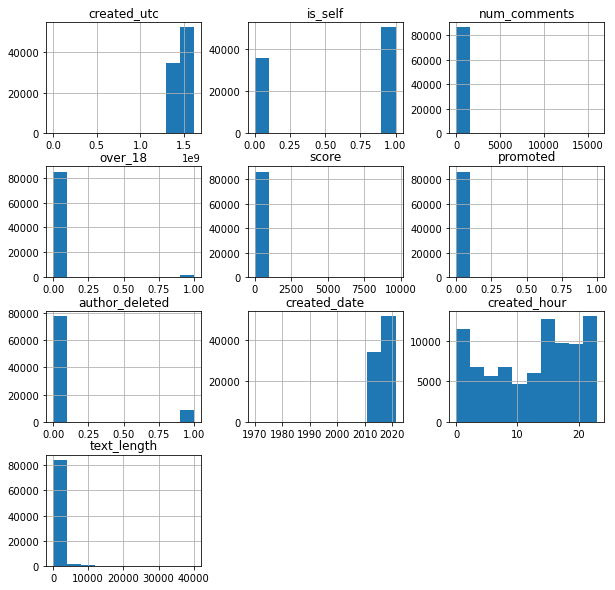

In [49]:
submissions_df.hist(figsize=(10, 10))
plt.tight_layout;

For features that are not booleans or in relation to date the distributions are very heavily positively skewed. These distributions also show that there are some very large outliers, however, these outliers may provide important information later on and a model that can handle outliers should be used.

In [50]:
submissions_df.groupby(by='is_self').mean()

,created_utc,num_comments,over_18,score,promoted,author_deleted,created_hour,text_length
is_self,,,,,,,,
0,1.520582e+09,12.080738,0.021473,23.630167,0.010723,0.104344,12.717777,62.065638
1,1.498883e+09,16.289648,0.021357,10.634770,0.000000,0.093214,12.331313,1099.839782


In [51]:
submission_authors = submissions_df.groupby(by='author').agg({
    'id': 'count',
    'is_self': 'mean',
    'num_comments': 'mean',
    'score': 'mean',
    'text_length': 'mean'
#     'subreddit': join_text,
})

In [52]:
submission_authors.reset_index(inplace=True)

### Comments EDA

In [53]:
comments_df.head()

,CommentID,AuthorID,Body,CreatedUTC,Edited,IsSubmitter,LinkID,ParentID,Score,SubredditID,has_author,created_date,created_hour
0,cwnj5aq,5u01v,1. Yes you should be able to run at ultra.\n2....,1446595365,0,0,t3_3rf9yg,t3_3rf9yg,2,t5_2sgp1,1,2015-11-04 00:02:45,0
1,cwnj5cs,axyl0,Your gonna have to wait till the game comes ou...,1446595368,0,0,t3_3rf9yg,t3_3rf9yg,1,t5_2sgp1,1,2015-11-04 00:02:48,0
2,cwnj5tv,lc8hr,1. Probably.\n2. N/A\n3. Wait for the sale.,1446595389,0,0,t3_3rf9yg,t3_3rf9yg,0,t5_2sgp1,1,2015-11-04 00:03:09,0
3,cwnj8h9,db1a5,"Alright, thank you!",1446595507,0,1,t3_3rf9yg,t1_cwnj5aq,1,t5_2sgp1,1,2015-11-04 00:05:07,0
4,cwnj8jz,7tb54,https://www.youtube.com/watch?v=OyJbSxpjrf8\n\...,1446595510,0,0,t3_3rfaem,t3_3rfaem,1,t5_2qnzu,1,2015-11-04 00:05:10,0


In [54]:
comments_df['body_length'] = comments_df['Body'].apply(lambda x: len(x))

In [55]:
comments_df.describe()

,CreatedUTC,Edited,IsSubmitter,Score,has_author,created_hour,body_length
count,1.644080e+05,164408.000000,164408.000000,164408.000000,164408.000000,164408.000000,164408.000000
mean,1.446879e+09,4.365992,0.051834,5.316396,0.837003,12.355992,131.067497
std,4.450950e+05,23.139195,0.221693,45.151458,0.369364,7.484467,246.184441
min,1.446595e+09,0.000000,0.000000,-214.000000,0.000000,0.000000,0.000000
25%,1.446739e+09,0.000000,0.000000,1.000000,1.000000,5.000000,21.000000
50%,1.446850e+09,0.000000,0.000000,1.000000,1.000000,14.000000,65.000000
75%,1.446993e+09,0.000000,0.000000,2.000000,1.000000,19.000000,149.000000
max,1.557539e+09,127.000000,1.000000,5792.000000,1.000000,23.000000,9997.000000


In [56]:
comments_df['Edited'].value_counts(normalize=True)

0      0.965622
127    0.034378
Name: Edited, dtype: float64

In [57]:
comments_df['IsSubmitter'].value_counts(normalize=True)

0    0.948166
1    0.051834
Name: IsSubmitter, dtype: float64

In [58]:
comment_authors = comments_df.groupby(by='AuthorID').agg({
    'CommentID': 'count',
    'body_length': 'mean',
    'Edited': 'mean',
    'IsSubmitter': 'mean',
    'Score': 'mean'
})
comment_authors.rename(columns={'CommentID': 'comment_count',
                                'body_length': 'avg_comment_length',
                                'Edited': 'avg_edited_comments',
                                'IsSubmitter': 'avg_is_submitter',
                                'Score': 'avg_comment_score'}, inplace=True)

In [59]:
comment_authors.reset_index(inplace=True)

### Users EDA

In [60]:
users_df.head()

,UserID,CommentKarma,CreatedUTC,VerifiedEmail,IsEmployee,IsMod,IsGold,LinkKarma,Name,created_date,created_hour
0,11r6v,109958,1170109022,1,0,1,0,2608,apullin,2007-01-29 22:17:02,22
1,12kj8,248529,1170444518,1,0,0,1,28625,antillus,2007-02-02 19:28:38,19
2,12n8k,35612,1170485799,1,0,0,0,614,caster,2007-02-03 06:56:39,6
3,12tkh,108198,1170611837,1,0,1,0,48457,THEMACGOD,2007-02-04 17:57:17,17
4,139sx,81138,1170827928,1,0,0,0,5823,puttysan,2007-02-07 05:58:48,5


In [61]:
# Appendix Code Ref 2
users_df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,CommentKarma,CreatedUTC,VerifiedEmail,IsEmployee,IsMod,IsGold,LinkKarma,created_hour
count,57968.00000,57968.00000,57968.00000,57968.00000,57968.00000,57968.00000,57968.00000,57968.00000
mean,28790.50000,1373306483.59140,0.84666,0.00002,0.26213,0.01340,6779.04518,12.03840
std,79202.92178,47765894.69372,0.36032,0.00415,0.43980,0.11500,52015.59252,7.52167
min,-100.00000,1123732800.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
25%,1033.00000,1340389248.75000,1.00000,0.00000,0.00000,0.00000,115.00000,5.00000
50%,5794.00000,1378533772.00000,1.00000,0.00000,0.00000,0.00000,919.00000,13.00000
75%,24528.25000,1412020082.25000,1.00000,0.00000,1.00000,0.00000,4320.00000,19.00000
max,4595096.00000,1459022357.00000,1.00000,1.00000,1.00000,1.00000,5531552.00000,23.00000


**Check for imbalanced columns that may note be helpful**

In [62]:
users_df['VerifiedEmail'].value_counts(normalize=True)

1    0.846657
0    0.153343
Name: VerifiedEmail, dtype: float64

In [63]:
users_df['IsMod'].value_counts(normalize=True)

0    0.737873
1    0.262127
Name: IsMod, dtype: float64

In [64]:
users_df['IsEmployee'].value_counts()

0    57967
1        1
Name: IsEmployee, dtype: int64

In [65]:
users_df['IsGold'].value_counts()

0    57191
1      777
Name: IsGold, dtype: int64

**Notes:**  
Exclude `IsEmployee` and `IsGold` from the model as most of the users are `False`

In [66]:
users_df.drop(columns=['IsEmployee', 'IsGold'], inplace=True)

In [67]:
users_df['name_length'] = users_df['Name'].map(lambda x: len(x))

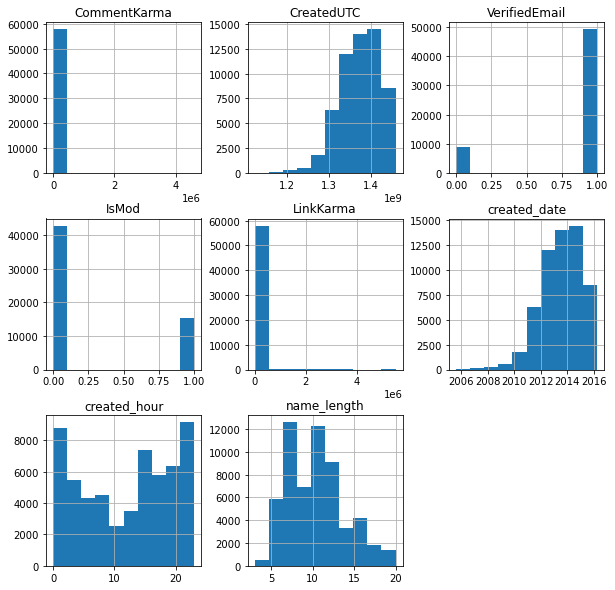

In [68]:
users_df.hist(figsize=(10, 10));

## Final Dataset

**Merge Data**

In [69]:
df = pd.merge(users_df, comment_authors, 
              how='left',
              left_on='UserID', 
              right_on='AuthorID',
              suffixes=('', 'comments'))
df.head()

,UserID,CommentKarma,CreatedUTC,VerifiedEmail,IsMod,LinkKarma,Name,created_date,created_hour,name_length,AuthorID,comment_count,avg_comment_length,avg_edited_comments,avg_is_submitter,avg_comment_score
0,11r6v,109958,1170109022,1,1,2608,apullin,2007-01-29 22:17:02,22,7,11r6v,1,148.0,0.0,0.0,1.000000
1,12kj8,248529,1170444518,1,0,28625,antillus,2007-02-02 19:28:38,19,8,12kj8,1,123.0,0.0,0.0,3.000000
2,12n8k,35612,1170485799,1,0,614,caster,2007-02-03 06:56:39,6,6,12n8k,1,273.0,0.0,0.0,13.000000
3,12tkh,108198,1170611837,1,1,48457,THEMACGOD,2007-02-04 17:57:17,17,9,12tkh,2,47.5,0.0,0.0,-0.500000
4,139sx,81138,1170827928,1,0,5823,puttysan,2007-02-07 05:58:48,5,8,139sx,3,144.0,0.0,0.0,2.333333


In [70]:
df.isna().sum()

UserID                 0
CommentKarma           0
CreatedUTC             0
VerifiedEmail          0
IsMod                  0
LinkKarma              0
Name                   0
created_date           0
created_hour           0
name_length            0
AuthorID               0
comment_count          0
avg_comment_length     0
avg_edited_comments    0
avg_is_submitter       0
avg_comment_score      0
dtype: int64

**Check for null values after merging submissions**

In [71]:
pd.merge(df, submission_authors, 
         how='left', 
         left_on='Name', 
         right_on='author',
         suffixes=('', 'submissions')).isna().sum()

UserID                     0
CommentKarma               0
CreatedUTC                 0
VerifiedEmail              0
IsMod                      0
LinkKarma                  0
Name                       0
created_date               0
created_hour               0
name_length                0
AuthorID                   0
comment_count              0
avg_comment_length         0
avg_edited_comments        0
avg_is_submitter           0
avg_comment_score          0
author                 52791
id                     52791
is_self                52791
num_comments           52791
score                  52791
text_length            52791
dtype: int64

In [72]:
df.describe()

,CommentKarma,CreatedUTC,VerifiedEmail,IsMod,LinkKarma,created_hour,name_length,comment_count,avg_comment_length,avg_edited_comments,avg_is_submitter,avg_comment_score
count,5.796800e+04,5.796800e+04,57968.000000,57968.000000,5.796800e+04,57968.000000,57968.000000,57968.000000,57968.000000,57968.000000,57968.000000,57968.000000
mean,2.879050e+04,1.373306e+09,0.846657,0.262127,6.779045e+03,12.038400,10.428392,2.365823,104.341948,2.428413,0.027346,4.780143
std,7.920292e+04,4.776589e+07,0.360321,0.439795,5.201559e+04,7.521669,3.401345,4.610707,179.430900,14.594103,0.155004,35.275886
min,-1.000000e+02,1.123733e+09,0.000000,0.000000,1.000000e+00,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,-52.000000
25%,1.033000e+03,1.340389e+09,1.000000,0.000000,1.150000e+02,5.000000,8.000000,1.000000,16.000000,0.000000,0.000000,1.000000
50%,5.794000e+03,1.378534e+09,1.000000,0.000000,9.190000e+02,13.000000,10.000000,1.000000,56.000000,0.000000,0.000000,1.000000
75%,2.452825e+04,1.412020e+09,1.000000,1.000000,4.320000e+03,19.000000,13.000000,2.000000,127.000000,0.000000,0.000000,2.000000
max,4.595096e+06,1.459022e+09,1.000000,1.000000,5.531552e+06,23.000000,20.000000,290.000000,9990.000000,127.000000,1.000000,2851.000000


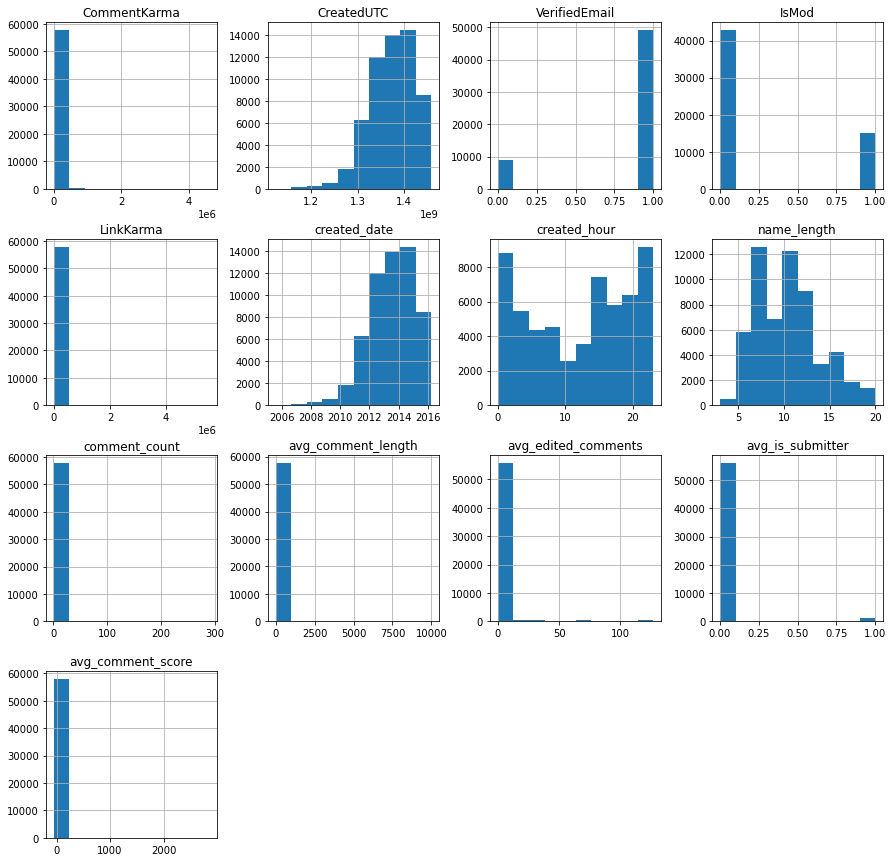

In [73]:
df.hist(figsize=(15, 15));

**Drop unnecessary or redundant columns**

In [74]:
df.drop(columns=['AuthorID'], inplace=True)

**Data Dictionary**

|Feature|type|Dataset|Description|
| :--- | :--- | :--- | :--- |
|UserID|*String*|Users|Unique ID given to each user by Reddit, base 36.|
|CommentKarma|*int64*|Users|Total karma score accumulated by user from comments.|
|CreatedUTC|*int64*|Users|Created date and time of the user account in seconds.|
|VerifiedEmail|*int64*|Users|Whether the user has a verified email (boolean).|
|IsMod|*int64*|Users|Whether the user is a mod of any subreddit (boolean).|
|LinkKarma|*int64*|Users|Total karma score accumulated by user from submissions.|
|Name|*String*|Users|User name.|
|created_date|*datetime64*|Users|Date that user created their account.|
|created_hour|*int64*|Users|Hour that user account was created (1 - 24).|
|name_length|*int64*|Users|Length of username.|
|comment_count|*int64*|Comments|Number of comments posted by user.|
|avg_comment_length|*float64*|Comments|Average comment length.|
|avg_edited_comments|*float64*|Comments|Percentage of comments that were edited by user.|
|avg_is_submittter|*float64*|Comments|Percentage of comments where the user posted the submission in which they commented.|
|avg_comment_score|*float64*|Comments|Average comment score (karma).|

## Modeling  
Agglomerative Clustering and DBSCAN as models, using Silhouette Score as the model metric.
* Keeping outliers.
* Standard Scale

### Selecting Features

Don't have enough ram, must reduce size of dataset.

In [76]:
df = df[:40_000]

In [77]:
X = df[[  # .265
    'CommentKarma',  # .299
#     'CreatedUTC',  # .37
    'VerifiedEmail',  # .271
#     'IsMod',  # .344
    'LinkKarma',  # .277
#     'name_length',  # .383
    'comment_count',  # .300
    'avg_is_submitter',  # .281
#     'avg_comment_length',  # .322
    'avg_comment_score'  # .281
]].values

In [78]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

### Agglomerative Clustering

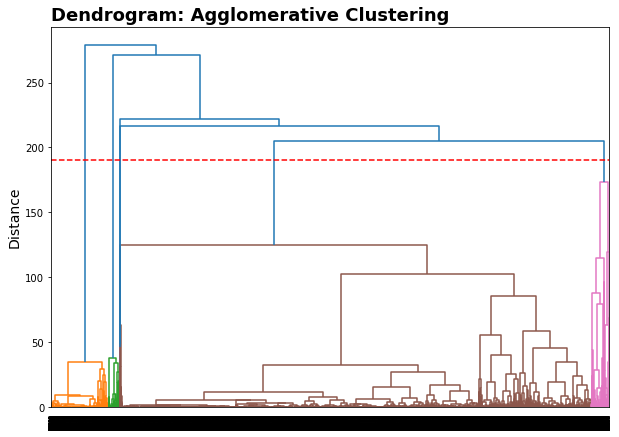

In [79]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram: Agglomerative Clustering",
          loc='left',
          fontweight='bold',
          fontsize=18)
plt.ylabel('Distance', fontsize=14)
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.axhline(y=190, color='r', linestyle='--')
plt.savefig('./images/dendrogram.png')

**Interpretation:**  
Above is a dendrogram of the for the dataset. The longest distance between samples is overall on the right, however, looking at the whole tree it seems as if the distance threshold is around 170, which cuts the dendrogram at 6 or 7 points or clusters.

In [80]:
aggl_6 = AgglomerativeClustering(n_clusters=6)
aggl_6.fit(X_scaled)

silhouette_score(X_scaled, aggl_6.labels_)

0.741746890608749

### DBSCAN

In [81]:
dbscan = DBSCAN(eps=.75, min_samples=12)
dbscan.fit(X_scaled)

DBSCAN(eps=0.75, min_samples=12)

In [82]:
silhouette_score(X_scaled, dbscan.labels_)

0.6750454377479989

## Cluster Analysis  
The model with the best silhouette score is the Agglomerative Clustering Model. Use this model to look for patterns in each cluster group.

In [83]:
df['cluster'] = aggl_6.labels_

In [84]:
df.groupby('cluster').mean().T.apply(lambda s: s.apply('{0:.2f}'.format))

cluster,0,1,2,3,4,5
CommentKarma,317865.52,1314544.25,25660.37,19023.37,203750.60,16880.77
CreatedUTC,1336813520.37,1370720540.25,1349456156.14,1359887518.56,1312777316.30,1355127240.04
VerifiedEmail,0.96,1.00,1.00,0.00,0.90,0.91
IsMod,0.58,1.00,0.30,0.14,0.40,0.28
LinkKarma,66036.48,4343624.50,5622.83,1954.57,5517.00,10451.91
created_hour,12.18,13.25,11.99,11.75,8.80,11.79
name_length,10.49,9.75,10.08,10.74,9.80,10.17
comment_count,11.59,4.50,1.94,1.76,1.30,4.06
avg_comment_length,162.32,699.50,102.34,102.40,158.80,141.55
avg_edited_comments,3.17,0.00,2.47,2.57,12.70,2.72


**Interpretation:**  
Above is a table of the means for each column separated by cluster. The columns that show interesting differences between mean by cluster are `LinkKarma`, `comment_count`, `avg_is_submitter`, `avg_comment_score`.

C:\Users\Sam\anaconda3\envs\ga-dsir-capstone\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Sam\anaconda3\envs\ga-dsir-capstone\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


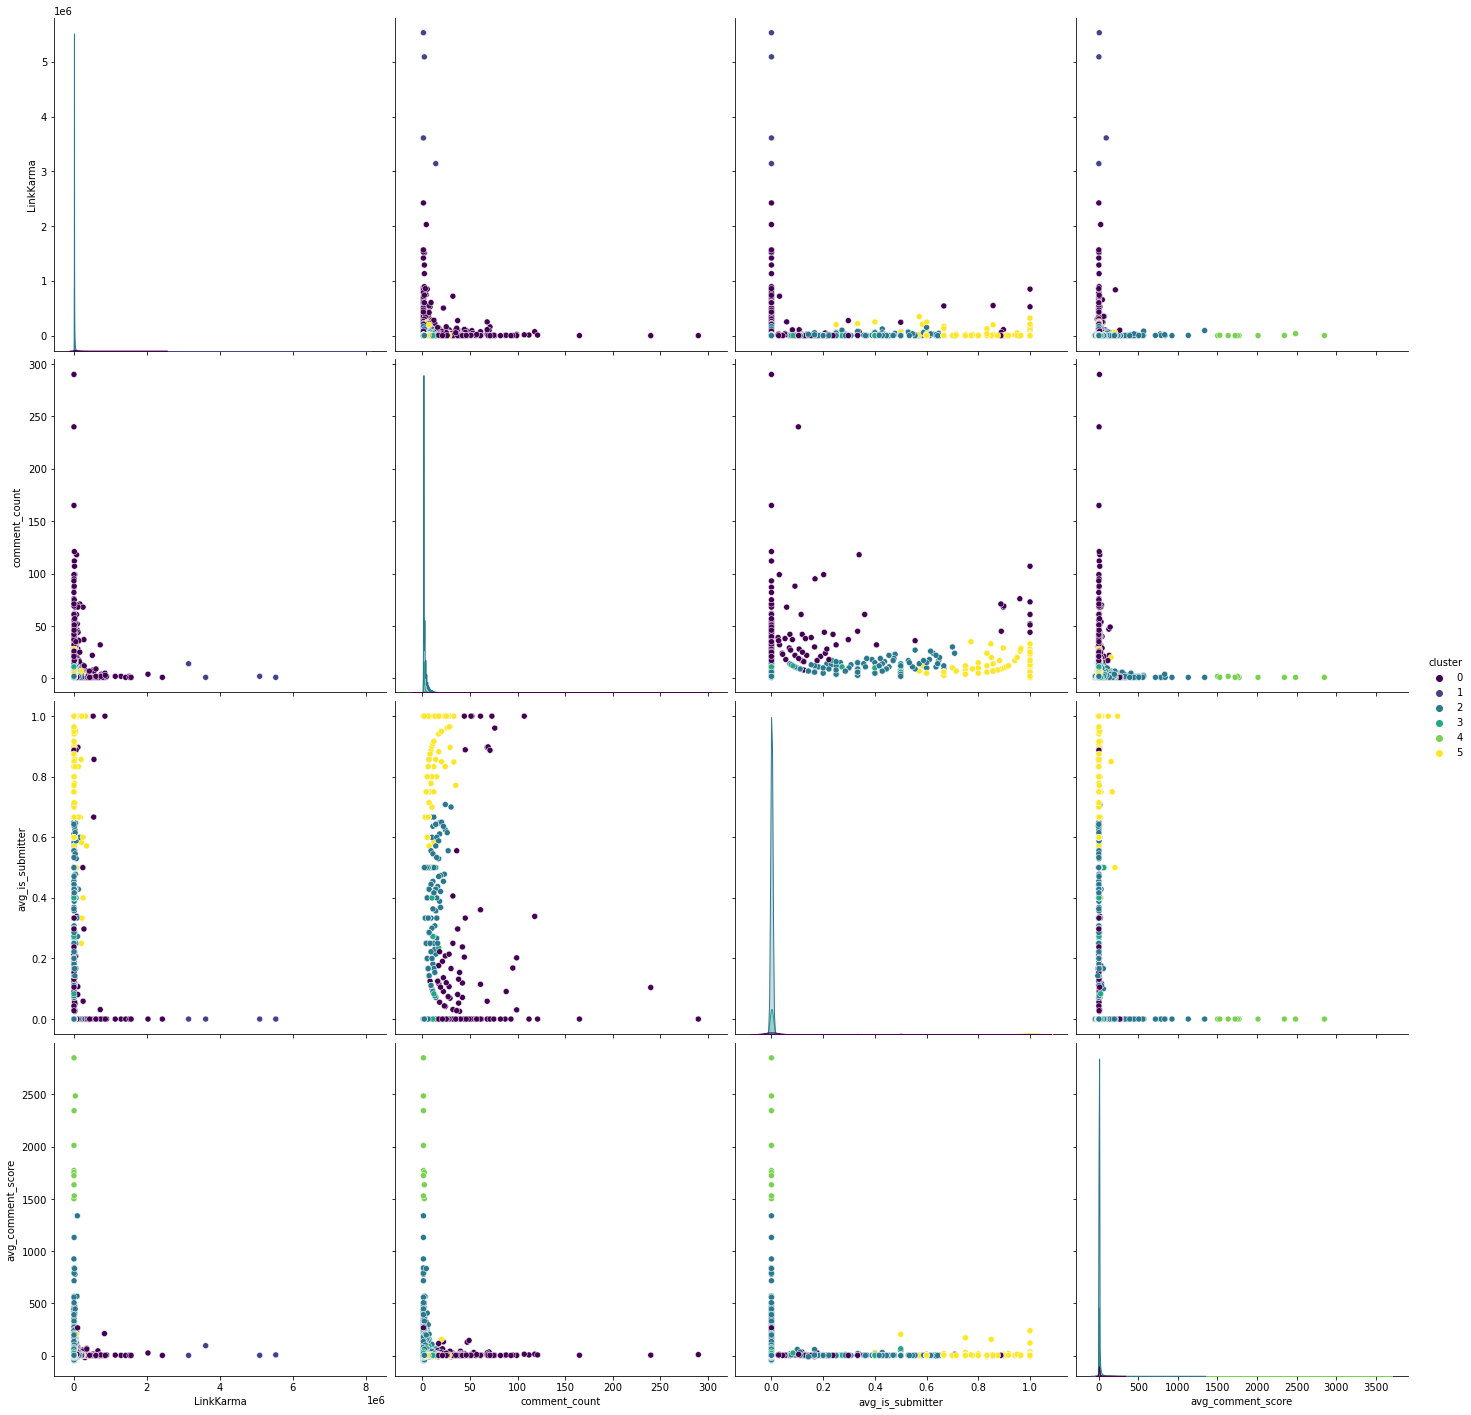

In [85]:
sns.pairplot(df[['cluster',
                 'LinkKarma',
                 'comment_count',
                 'avg_is_submitter',
                 'avg_comment_score',
                ]], 
             hue='cluster', 
             palette='viridis',
             height=5);

**Interpretation:**  
Above is a pairplot of the features that had the most interesting difference in means per cluster. One immediate trend is that all of the distributions are very heavily positively skewed therefore it probably makes sense that these features have the most interesting means per cluster. 

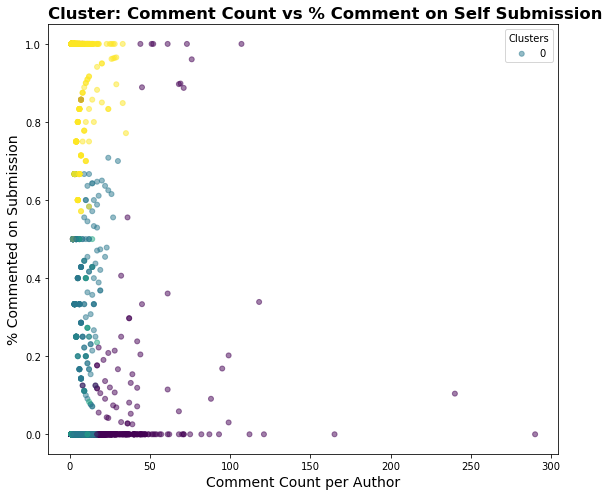

In [95]:
plt.figure(figsize=(8, 7))
plt.scatter(df['comment_count'], df['avg_is_submitter'], 
            c=df['cluster'], 
            cmap='viridis',
            alpha=.5,
            s=25);
plt.title('Cluster: Comment Count vs % Comment on Self Submission',
          loc='left',
          fontweight='bold',
          fontsize=16.5)
plt.xlabel('Comment Count per Author', fontsize=14)
plt.ylabel('% Commented on Submission', fontsize=14)
plt.legend([0, 1, 2, 3, 4, 5], title='Clusters')
plt.tight_layout()
plt.savefig('./images/cluster_comment_count_vs_%_comment_submission.png');

**Interpretation:**  

## Results & Conclusions

Although a silhouette score of 0.741 is not great the differences in mean between some features of the dataset indicate that there are features that can be used to segment reddit users. The most notable features are `LinkKarma`, `comment_count`, `avg_is_submitter`, and `avg_comment_score`. 

`CommentKarma` and `LinkKarma` seem to be the best separators of clusters as most clusters have very distinct mean values for these two features. On the other hand there are multiple features such as `avg_comment_score` and `comment_count` that are distinct for some clusters but for others have very similar mean values. However, these differences seem to note that there is segmentation in reddit users by how much karma they have accumulated, how much they post, and their average score per post or comment. This is unsurprising and expected, further analysis needs to be done using NLP to get a better idea of user segmentation.

## Next Steps

Immediate next steps for this project include moving the process into a cloud service, collecting more data, and conducting NLP on comments and submissions. Collecting more data would include using variations of the video game name to search for submissions that should be included within the dataset. For example 'Sid Meier's Civilization® V', could have been refered to as 'Civilization V', 'Civ 5', or 'Civ V', among other names. Additionally, all posts from each user could be pulled during the same time period as the submissions. This would allow for a deeper analysis of reddit users such as the total comments vs comments about the video game could be compared and overall NLP of all comments the user posted, allowing for a more nuanced model.

NLP could be used to build a better picture of typical reddit users and to check the overall sentiment of users pre and post release date of a game. Further features can be engineered through looking at self focus vs other people, parts of speech usage, and overall sentiment analysis.
    
The next step, conceptually, for this project is to use clustered users, comments, and submission data split into pre and post subsets to predict video game sales based on features such as overall sentiment change pre and post launch and the percentage of users withing different clusters posting comments and submissions.